## Capstone


In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import cv2
import pickle as pkl
import matplotlib.pyplot as plt

## Load the Dataset


In [2]:
trainx = torch.load(r'C:\Users\LC\Desktop\csci-ua-473-intro-to-machine-learning-fall22\train\train\trainX.pt')

In [3]:
trainy = torch.load(r'C:\Users\LC\Desktop\csci-ua-473-intro-to-machine-learning-fall22\train\train\trainY.pt')

In [4]:
testx = torch.load(r'C:\Users\LC\Desktop\csci-ua-473-intro-to-machine-learning-fall22\test\test\testX.pt')

In [5]:
print(np.shape(trainx[0]))
print(np.shape(trainx[1]))
print(np.shape(trainx[2]))

torch.Size([3396, 3, 3, 224, 224])
torch.Size([3396, 3, 224, 224])
(3396,)


In [6]:
import os
import numpy as np
import pickle as pkl
import torch
from torchvision.utils import save_image

num_train = trainx[0].shape[0]
num_test = testx[0].shape[0]

os.makedirs('./lazydata', exist_ok=True)

# Save train data
os.makedirs('./lazydata/train', exist_ok=True)
os.makedirs('./lazydata/train/X', exist_ok=True)
os.makedirs('./lazydata/train/Y', exist_ok=True)
for i in range(num_train):
    os.makedirs('./lazydata/train/X/{}'.format(i), exist_ok=True)
    # rgb
    os.makedirs('./lazydata/train/X/{}/rgb'.format(i), exist_ok=True)
    for j in range(3):
        save_image(trainx[0][i][j]/255, './lazydata/train/X/{}/rgb/{}.png'.format(i, j))
    # depth
    depth = trainx[1][i].numpy()
    np.save('./lazydata/train/X/{}/depth.npy'.format(i), depth)
    # field id
    pkl.dump(trainx[2][i], open('./lazydata/train/X/{}/field_id.pkl'.format(i), 'wb'))

    y = trainy[0][i].numpy()
    np.save('./lazydata/train/Y/{}.npy'.format(i), y)
print("Saved train data")

# Save test data
os.makedirs('./lazydata/test', exist_ok=True)
os.makedirs('./lazydata/test/X', exist_ok=True)
for i in range(num_test):
    os.makedirs('./lazydata/test/X/{}'.format(i), exist_ok=True)
    # rgb
    os.makedirs('./lazydata/test/X/{}/rgb'.format(i), exist_ok=True)
    for j in range(3):
        save_image(testx[0][i][j]/255, './lazydata/test/X/{}/rgb/{}.png'.format(i, j))
    # depth
    depth = testx[1][i].numpy()
    np.save('./lazydata/test/X/{}/depth.npy'.format(i), depth)
    # field id
    pkl.dump(testx[2][i], open('./lazydata/test/X/{}/field_id.pkl'.format(i), 'wb'))

print("Saved test data")

Saved train data
Saved test data


In [2]:
class LazyLoadDataset(Dataset):    
    def __init__(self, path, train=True, transform=None):
        self.transform=transform
        path = path + ("train/" if train else "test/")
        
        self.pathX=path+"X/"
        self.pathY=path+"Y/"
        
        self.data=os.listdir(self.pathX)
        
    def __getitem__(self, idx):
        f=self.data[idx]
        
        #X
        #read rgb images
        img0=cv2.imread(self.pathX + f +"/rgb/0.png")
        img1=cv2.imread(self.pathX + f +"/rgb/1.png")
        img2=cv2.imread(self.pathX + f +"/rgb/2.png")
        if self.transform is not None:
            img0=self.transform(img0)
            img1=self.transform(img1)
            img2=self.transform(img2)
        depth = np.load(self.pathX + f + "/depth.npy")
        field_id = pkl.load(open(self.pathX + f + "/field_id.pkl", "rb"))
        Y = np.load(self.pathY + f + ".npy")
        return (img0, img1, img2, depth, field_id),Y
    def _len_(self):
        return len(self.data)

In [3]:
dataset = LazyLoadDataset("./lazydata/")  #length 3396

### 2.CNN

IndexError: tuple index out of range

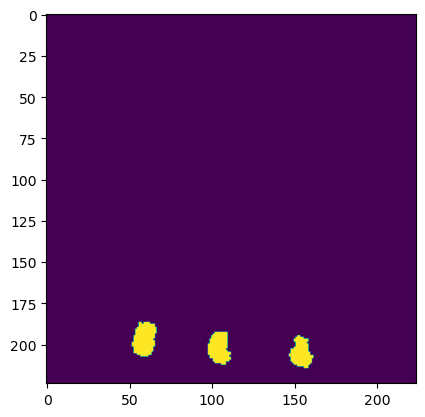

In [39]:
def findFingerTips(img, fingertips):
    blurred = cv2.blur(fingertips,(2,2))
    ret,thresh=cv2.threshold(blurred,0,255,cv2.THRESH_BINARY)
    plt.imshow(thresh)
    contours,hierarchy= cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img,contours,-1,(255,255,0),4)
    result=[]
    for i in range (4):
        a=[0,0]
        if len(contours[i]) != 0 :
            for j in contours[i]:
                a=a+contours[i][0]
            a=a/len(contours[i]) 
        result.append(a)
    return result

for i in range (3):
    (img0, img1, img2, depth, field_id), Y= dataset[i]
    lower=np.array([121,190,120])
    upper=np.array([255,255,255])
    fingertips0=cv2.inRange(img0,lower,upper)
    fingertips1=cv2.inRange(img1,lower,upper)
    fingertips2=cv2.inRange(img2,lower,upper)
    temp=[]
    temp.append(findFingerTips(img0,fingertips0))  
    temp.append(findFingerTips(img1,fingertips1))  
    temp.append(findFingerTips(img2,fingertips2))  
    
   


In [4]:
(img0, img1, img2, depth, field_id), Y= dataset[0]
print (Y)


[ 0.02667237  0.05455598  0.12987244  0.02514074 -0.00112136  0.13262471
  0.03066019 -0.05429448  0.12896113  0.05547796  0.01084437 -0.06837047]


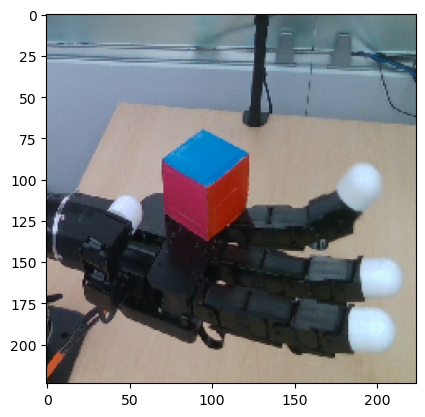

In [60]:

plt.imshow(img1[:,:,::-1])
#plt.imshow(depth[0])
plt.show()

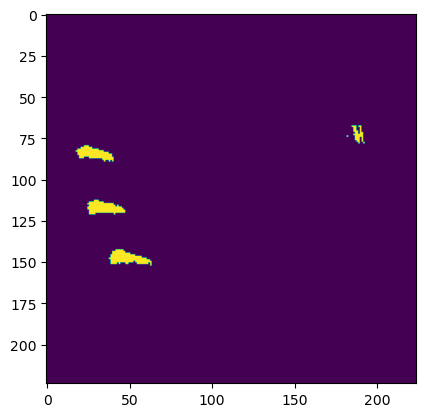

In [74]:
lower=np.array([210,210,170])
upper=np.array([255,255,255])
fingertips=cv2.inRange(img2,lower,upper)
plt.imshow(fingertips)

[[149. 194.]]
[[102. 192.]]
[[ 55. 187.]]
[[104.  41.]]


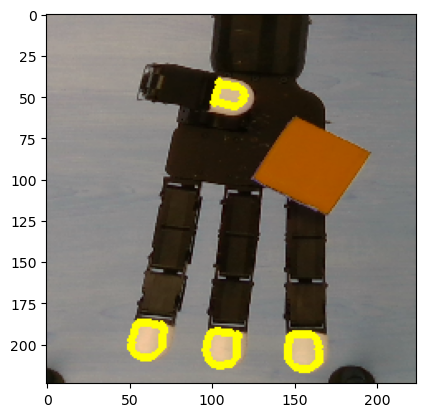

In [7]:
blurred = cv2.blur(fingertips,(2,2))
ret,thresh=cv2.threshold(blurred,0,255,cv2.THRESH_BINARY)
plt.imshow(thresh)
contours,hierarchy= cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img0,contours,-1,(255,255,0),4)
for i in range (4):
    a=[0,0]
    for j in contours[i]:
        a=a+contours[i][0]
    a=a/len(contours[i])
    print(a)        
plt.imshow(img0)


In [49]:
batch_size = 64
train_dataLoader = DataLoader(training_data, batch_size=batch_size, shuffle= True)
test_dataLoader = DataLoader(test_data, batch_size=2*batch_size)

NameError: name 'training_data' is not defined

## Train a Fully Connected Neural Network on MNIST

### Define the network

Build a 3-layer fully connected neural network that takes an input of size `784`, outputs `10` classes and has a hidden layer of size `(8,8)`. Use ReLU non-linearity and apply a logSoftmax function on the final layer.

The model must have the following architecture:

```
linear_layer(input_size, n_hidden)
relu
linear_layer(n_hidden, n_hidden)
relu
linear_layer(n_hidden, output_size)
log_softmax
```

In [ ]:
class FCN(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FCN, self).__init__()
        self.flatten =nn.Flatten()
        self.relu=nn.ReLU()
        self.LogSoftmax=nn.LogSoftmax(dim=1)
        self.linear1=nn.Linear(28*28,8)
        self.linear2=nn.Linear(8,8)
        self.linear3=nn.Linear(8,10)

    def forward(self, x):
        x=self.flatten(x)
        x=self.relu(self.linear1(x))
        x=self.relu(self.linear2(x))
        result=self.LogSoftmax(self.linear3(x))
        return result

### Define train and test function

Complete the function for training and evaluating the model. You must use the cross entropy loss function for training the model.

Note:
- `permute` is a function passed as an argument to train and test functions.
- `permutation_order` is a 1D torch array of size 784 (=28*28). It contains the random order for permutating the pixels in the `28x28` images.

In [ ]:
def train(epoch, model, optimizer, permute_pixels=None, permutation_order=None):
    """
    Train the model for one epoch

    Args:
        epoch (int): current epoch
        model (nn.Module): model to train
        optimizer (torch.optim): optimizer to use
        permute_pixels (function): function to permute the pixels (default: None)
        permutation_order (1D torch array): order of the permutation (default: None)
    """
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        if permute_pixels is not None:
            data = permute_pixels(data,permutation_order)

        optimizer.zero_grad()
        output = model(data)
        loss = nn.CrossEntropyLoss()(output,target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, permute_pixels=None, permutation_order=None):
    """
    Test the model

    Args:
        model (nn.Module): model to test
        permute (function): function to permute the pixels (default: None)
        permutation_order (1D torch array): order of the permutation (default: None)
    """
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        if permute_pixels is not None:
            data = permute_pixels(data,permutation_order)

        output = model(data)
        test_loss += nn.CrossEntropyLoss()(output,target).item() # sum up batch loss                                                               
        pred = model(data) # get the index of the max log-probability                                                                 
        correct += (pred.argmax(1)==target).type(torch.float).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))
    return accuracy

# Write a function for computing the total parameter count of the model

In [ ]:
# function to count number of parameters
def get_n_params(model):
    # return number of parameters in model
    return sum(p.numel() for p in model.parameters())

### Train a small fully-connected network

Optimizer : SGD with lr=0.01 and momentum=0.5

In [ ]:
n_hidden = 8 # number of hidden units

model_fcn = FCN(input_size, n_hidden, output_size)
model_fcn.to(device)
optimizer = torch.optim.SGD(model_fcn.parameters(), lr=0.01, momentum=0.5) # use SGD with learning rate 0.01 and momentum 0.5
print('Number of parameters: {}'.format(get_n_params(model_fcn)))

test_accuracy = []
for epoch in range(0, 1):
    train(epoch, model_fcn, optimizer)
    test_accuracy.append(test(model_fcn))

## Train a Convolutional Neural Network (CNN) on MNIST

Define a convolutional neural network with the following architecture to classify the MNIST images.

```
Conv(
    conv2D(input_size, conv_feature, kernel_size=5)
    relu()
    maxpool2d(kernel_size=2)
    conv2d(conv_feature, conv_feature, kernel_size=5)
    relu()
    maxpool2d(kernel_size=2)
)

FC(
    linear_feature(conv_feature*4*4, fc_feature),
    relu(),
    linear_feature(fc_feature, output_size),
    log_softmax()
)
```

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_size, conv_feature, fc_feature, output_size):
        super(CNN, self).__init__()
        self.flatten =nn.Flatten()
        self.conv1 = nn.Conv2d(input_size,conv_feature, 5)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(conv_feature, conv_feature,5)
        self.fc1 = nn.Linear(conv_feature*4*4, fc_feature)
        self.fc2 = nn.Linear(fc_feature,output_size)
        self.logSoftmax=nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.maxpool(self.relu(self.conv1(x)))
        x = self.maxpool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        output = self.logSoftmax(x)
        return output

### Train a ConvNet with the same number of parameters

In [ ]:
# Training settings 
conv_features = 6 # number of feature maps
fc_features = 50

model_cnn = CNN( 1, conv_features, fc_features, output_size) # create CNN model
model_cnn.to(device)
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5) # use SGD with learning rate 0.01 and momentum 0.5
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

test_accuracy = []
for epoch in range(0, 1):
    train(epoch, model_cnn, optimizer)
    test_accuracy.append(test(model_cnn))

### Question: Why do you think the ConvNet performs better than the fully connected network even though both have the same number of parameters?


Because ConvNet helps reducing dimensions of the output features. It helps to extract the "sharpest features" while downsampling. Therefore, ConvNet performs better than the fully connected network even though both have the same number of parameters.

### What happens if the assumptions are no longer true?

In [ ]:
# Given a permutation order, permute the pixels of the input image
def permute_pixels(data, permutation_order):
    """
    Permute the pixels of the input image
    
    Args:
        data (torch tensor): batch of input images of shape (B, H, W) where B is the batch size, H is the height and W is the width.
        permutation_order (1D torch array): order of the permutation
    
    Returns:
        permuted_data (torch tensor): permuted batch of input images of shape (B, 1, H, W)
    """
    data = torch.stack([x.view(-1)[permutation_order].view(1, 28, 28) for x in data], dim=0)
    
    return data

In [ ]:
permutation_order = torch.randperm(28*28)

plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    image = image[None, :]
    # permute pixels
    image_perm = permute_pixels(image.clone(), permutation_order)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

### ConvNet with permuted pixels

Train and evaluate a ConvNet with permuted pixels.

In [ ]:
# Training settings 
conv_features = 6 # number of feature maps
fc_features = 50

model_cnn = CNN( 1, conv_features, fc_features, output_size) # create CNN model
model_cnn.to(device)
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5) # use SGD with learning rate 0.01 and momentum 0.5
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, optimizer, permute_pixels, permutation_order)
    test(model_cnn, permute_pixels, permutation_order)

### Fully-Connected with Permuted Pixels

Train and evaluate a fully connected network with permuted pixels.

In [ ]:
n_hidden = 8    # number of hidden units

model_fnn = FCN(input_size, n_hidden, output_size) # create FCN model
model_fnn.to(device)
optimizer = torch.optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5) # use SGD with learning rate 0.01 and momentum 0.5
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, optimizer, permute_pixels,permutation_order)
    test(model_fnn, permute_pixels, permutation_order)

### Question: We observe that the ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same. Provide an explanation for this.

ConvNet makes the assumption that pixels lie on a grid are stationary, and it loses performance when this assumption is wrong.
However, the fully-connected network does not make this assumption. It does less well when it is true, since it doesn't take advantage of this prior knowledge,but it doesn't suffer when the assumption is wrong.